# Install libs


In [1]:
!git clone https://github.com/ai-forever/diffusers
!pip install /content/diffusers
!pip install transformers
!pip install accelerate
!pip install fastparquet

Cloning into 'diffusers'...
remote: Enumerating objects: 25012, done.
remote: Counting objects: 100% (776/776), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 25012 (delta 489), reused 590 (delta 384), pack-reused 24236
Receiving objects: 100% (25012/25012), 18.54 MiB | 25.38 MiB/s, done.
Resolving deltas: 100% (18179/18179), done.
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.1 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.19.0.dev0-py3-none-any.whl size=1251198 sha256=6a851360b9c48c739e55631130030e6eba992781ff8d7238f053f7cfd7a8794a
  Stored in directory: /tmp/pip-ephem-wheel-cache-32_03_f6/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.2 MB/s eta 0:00:00
     

# Download dataset and prepare dataset



In [2]:
%%capture
!wget https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions/resolve/main/data/train-00000-of-00001-566cc9b19d7203f8.parquet

In [3]:
import pandas as pd
from PIL import Image
import io
import os
df_dataset = pd.read_parquet('/content/train-00000-of-00001-566cc9b19d7203f8.parquet', engine='fastparquet')

In [4]:
df_dataset

,text,image.bytes,image.path
0,a drawing of a green pokemon with red eyes,b'\xff\xd8\xff\xe1#\rExif\x00\x00MM\x00*\x00\x...,None
1,a green and yellow toy with a red nose,b'\xff\xd8\xff\xe1#\x98Exif\x00\x00MM\x00*\x00...,None
2,a red and white ball with an angry look on its...,b'\xff\xd8\xff\xe1\x18\x82Exif\x00\x00MM\x00*\...,None
3,a cartoon ball with a smile on it's face,b'\xff\xd8\xff\xe1\x1a\x06Exif\x00\x00MM\x00*\...,None
4,a bunch of balls with faces drawn on them,b'\xff\xd8\xff\xe1\x1d\xe3Exif\x00\x00MM\x00*\...,None
...,...,...,...
828,a cartoon picture of a stone dragon,b'\xff\xd8\xff\xe1\x1e\xb1Exif\x00\x00MM\x00*\...,None
829,a drawing of a yellow and gray pokemon character,b'\xff\xd8\xff\xe1\x1a/Exif\x00\x00MM\x00*\x00...,None
830,a drawing of a cat with a wheel in his hand,b'\xff\xd8\xff\xe1!\xcdExif\x00\x00MM\x00*\x00...,None
831,a drawing of a cartoon character with two eyes,b'\xff\xd8\xff\xe1\x1cLExif\x00\x00MM\x00*\x00...,None


In [5]:
dir_name = '/content/images'
os.mkdir(dir_name)

In [6]:
df = []
for i in range(len(df_dataset)):
    image = Image.open(io.BytesIO(df_dataset['image.bytes'].iloc[i]))
    img_path = os.path.join(dir_name, f'{i}.jpg')
    image.save(img_path)
    df.append([img_path, df_dataset['text'].iloc[i]])
df = pd.DataFrame(df)
df.columns = ['paths', 'caption']
df.to_csv('captions.csv', index=False)

# Train

In [7]:
command = (f'python3 /content/diffusers/examples/kandinsky2_2_train/tune_decoder_lora.py '
           f'--train_images_paths_csv=/content/captions.csv '
           f'--image_resolution=768 '
           f'--train_batch_size=1 '
           f'--gradient_accumulation_steps=1 '
           f'--gradient_checkpointing '
           f'--mixed_precision="fp16"  '
           f'--max_train_steps=500 '
           f'--lr=1e-05 '
           f'--max_grad_norm=1 '
           f'--lr_scheduler="constant" '
           f'--lr_warmup_steps=0 '
           f'--output_dir=/content/decoder_lora_saves '
           f'--rank=4 '
           f'--checkpointing_steps=500')

In [8]:
!{command}

2023-07-12 18:23:37.352294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
{'trained_betas', 'sample_max_value', 'dynamic_thresholding_ratio', 'clip_sample_range', 'variance_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
{'addition_time_embed_dim', 'transformer_layers_per_block', 'num_attention_heads'} was not found in config. Values will be initialized to default values.
training goes brrr: 100% 500/500 [07:35<00:00,  1.10it/s, lr=1e-5, step_loss=0.216]


In [9]:
command = (f'python3 /content/diffusers/examples/kandinsky2_2_train/tune_prior_lora.py '
           f'--train_images_paths_csv=/content/captions.csv '
           f'--train_batch_size=1 '
           f'--gradient_accumulation_steps=1 '
           f'--gradient_checkpointing '
           f'--mixed_precision="fp16"  '
           f'--max_train_steps=500 '
           f'--lr=1e-05 '
           f'--max_grad_norm=1 '
           f'--lr_scheduler="constant" '
           f'--lr_warmup_steps=0 '
           f'--output_dir=/content/decoder_prior_saves '
           f'--rank=4 '
           f'--checkpointing_steps=500')

In [10]:
!{command}

2023-07-12 18:33:50.883556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
args.pretrained_prior_path = kandinsky-community/kandinsky-2-2-prior
{'time_embed_dim', 'encoder_hid_proj_type', 'embedding_proj_dim', 'norm_in_type', 'added_emb_type', 'clip_embed_dim', 'embedding_proj_norm_type', 'time_embed_act_fn'} was not found in config. Values will be initialized to default values.
training goes brrr: 100% 500/500 [02:07<00:00,  3.93it/s, lr=1e-5, step_loss=1.42]


In [11]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np

In [12]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained('kandinsky-community/kandinsky-2-2-prior', subfolder='image_encoder').to(torch.float16).to('cuda')
unet = UNet2DConditionModel.from_pretrained('kandinsky-community/kandinsky-2-2-decoder', subfolder='unet').to(torch.float16).to('cuda')
prior = KandinskyV22PriorPipeline.from_pretrained('kandinsky-community/kandinsky-2-2-prior', image_encoder=image_encoder, torch_dtype=torch.float16)
prior = prior.to("cuda")
decoder = KandinskyV22Pipeline.from_pretrained('kandinsky-community/kandinsky-2-2-decoder', unet=unet, torch_dtype=torch.float16)
decoder = decoder.to("cuda")

text_encoder/model.safetensors not found


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

movq/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
from diffusers.models.attention_processor import LoRAAttnProcessor, LoRAAttnAddedKVProcessor
lora_attn_procs = {}
d = torch.load('/content/decoder_lora_saves/checkpoint-500/pytorch_model.bin')
for name in decoder.unet.attn_processors.keys():
    cross_attention_dim = None if name.endswith("attn1.processor") else decoder.unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = decoder.unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(decoder.unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = decoder.unet.config.block_out_channels[block_id]
    lora_attn_procs[name] = LoRAAttnAddedKVProcessor(
            hidden_size=hidden_size,
            cross_attention_dim=cross_attention_dim,
            rank=4,
    ).to('cuda')

decoder.unet.set_attn_processor(lora_attn_procs)
decoder.unet.load_state_dict(d, strict=False)
None

In [17]:
from diffusers.models.attention_processor import LoRAAttnProcessor, LoRAAttnAddedKVProcessor
lora_attn_procs = {}
for name in prior.prior.attn_processors.keys():
    lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=2048).to('cuda')
prior.prior.set_attn_processor(lora_attn_procs)
prior.prior.load_state_dict(torch.load('/content/decoder_prior_saves/checkpoint-500/pytorch_model.bin'), strict=False)
None

In [20]:
negative_prior_prompt ='lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature'
torch.manual_seed(42)
img_emb = prior(prompt='A robot pokemon, 4k photo', num_inference_steps=25, num_images_per_prompt=1,)
negative_emb = prior(prompt=negative_prior_prompt, num_inference_steps=25, num_images_per_prompt=1)
images = decoder(image_embeds=img_emb.image_embeds, negative_image_embeds=negative_emb.image_embeds, num_inference_steps=50, height=512, width=512)


  0%|          | 0/25 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature']


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

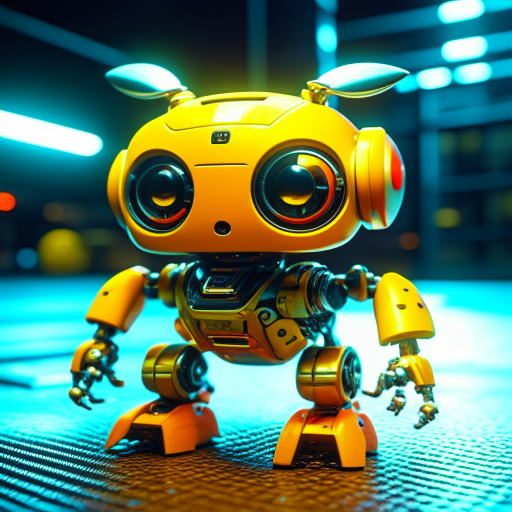

In [21]:
images.images[0]